In [11]:
import numpy as np
import tensorflow as tf
import deepxde as dde

# Define the geometry and time domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the heat equation
def heat_eqn(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=1, j=1)
    return du_t - du_xx

# Define the boundary condition
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def func(x):
    return np.sin(np.pi * x[:, 1:2])

bc_l = dde.DirichletBC(geomtime, func, boundary_l, component=0)
bc_r = dde.DirichletBC(geomtime, func, boundary_r, component=0)

# Define the initial condition
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

# Gather all components of the model
data = dde.data.TimePDE(
    geomtime,
    heat_eqn,
    [bc_l, bc_r, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=0.001)
model.train(epochs=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.050465 s

'compile' took 0.448174 s

Training model...

0         [3.02e-02, 3.71e-01, 6.20e-01, 2.60e-03]    [3.10e-02, 3.71e-01, 6.20e-01, 2.60e-03]    []  
1000      [1.94e-03, 6.88e-02, 6.21e-02, 5.36e-03]    [1.15e-03, 6.88e-02, 6.21e-02, 5.36e-03]    []  
2000      [1.25e-03, 6.87e-02, 6.14e-02, 1.60e-03]    [3.95e-04, 6.87e-02, 6.14e-02, 1.60e-03]    []  
3000      [1.32e-03, 6.87e-02, 6.14e-02, 4.19e-04]    [3.89e-04, 6.87e-02, 6.14e-02, 4.19e-04]    []  
4000      [1.30e-03, 6.87e-02, 6.13e-02, 1.04e-04]    [3.49e-04, 6.87e-02, 6.13e-02, 1.04e-04]    []  
5000      [1.26e-03, 6.87e-02, 6.13e-02, 6.13e-05]    [2.83e-04, 6.87e-02, 6.13e-02, 6.13e-05]    []  

Best model at step 5000:
  train loss: 1.31e-01
  test loss: 1.30e-01
  test metric: []

'train' took 12.430212 s



(<deepxde.model.LossHistory at 0x1e5f87c15e0>,
 <deepxde.model.TrainState at 0x1e5f87c1880>)

In [15]:
#simple rheometer flow
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib as plt
import numpy as np
import tensorflow as tf
#from deepxde.backend import tfhelper
#from deepxde.boundarycondition import BC



#Import BC at some point

#viscosity initial guess
eta =  dde.Variable(100.0)

#########################
#some properties of system
#radius in meters
R = 0.050 #5 cm
#height in meteres
H = 0.001 #1 mm
Lx_min = 0.001
Lx_max = R
Ly_min = 0
Ly_max = H
AngularVelocity = 1



#########################
#make domain
#our domain is pseudo steady state, time invariant. Axisymmetric wrt theta
#geom = dde.geometry.Rectangle([0, 0], [R, H])


#define our sysyem?
#x represents r,z, y represents theta
def rheometerPlate(x,y):
    Vdtheta =  y[:, 0:1]
    r = x[:,0:1]
    z = x[:,1:2]
    
    
    mult_Vtheta_r = Vdtheta*r
    print(mult_Vtheta_r)
    dVtheta_r = dde.grad.jacobian(mult_Vtheta_r, x, i=0) 
    
    Vtheta_rdiv =  dVtheta_r/(r)
    dVtheta_r_r = dde.grad.jacobian(Vtheta_rdiv, x, i=0) 
    dVtheta_zz = dde.grad.hessian(Vdtheta,x,i=1, j = 1)
    
    
    
     # calculate dV/dx
    #V_x = tf.gradients(V, x1)[0]  

    # calculate d/dx(1/x*dV/dx)
    # term = tf.gradients((1 / x1) * V_x, x1)[0]
    #we have indep variables t, theta and z, we have dep variabels theta. We have first order and second order things
    
    #eqn = ()
    return (eta*dVtheta_r_r+eta*dVtheta_zz)


space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

def boundary(_, on_initial):
    return on_initial

#ic1 = dde.icbc.IC(geom, lambda X: 1, boundary, component=0)


def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[1], Ly_max)

def func(x):
    return x[:, 0:1]  # for example

def boundary2(x, on_boundary):
    return on_boundary and np.isclose(x[0],Lx_min)
def boundary3(x, on_boundary):
    return on_boundary and np.isclose(x[1], Ly_min)    

#Top plate, needs to be velocity =0
bc = dde.DirichletBC(space_domain, lambda x: 0, boundary)

#center, velocity is 0
bc2 = dde.DirichletBC(space_domain, lambda x: 0, boundary2)
#bottom plate, velocity moves with angfular velocity
bc3 = dde.DirichletBC(space_domain, lambda x: AngularVelocity*x[0], boundary3)



data = dde.data.PDE(
    space_domain,
    rheometerPlate,
    [bc, bc2, bc3],
    num_domain=900,
    num_boundary=200
    #auxiliary_var_function=ex_func2,
)



net = dde.nn.FNN([2] + [80] * 4 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = []
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=200, filename="variables.dat"
)

# train adam
model.compile(
    "adam", lr=0.001, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=5000, callbacks=[variable])

# train lbfgs
#model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
#losshistory, train_state = model.train(callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)





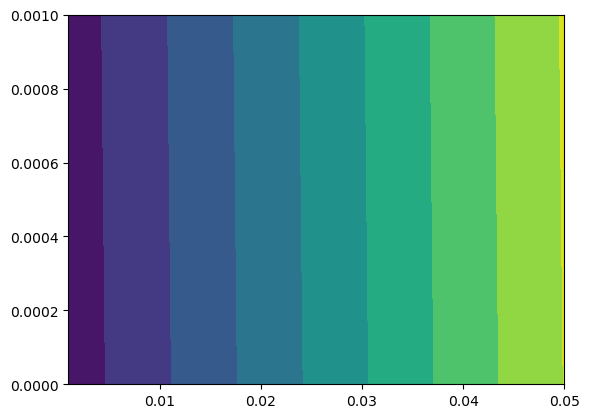

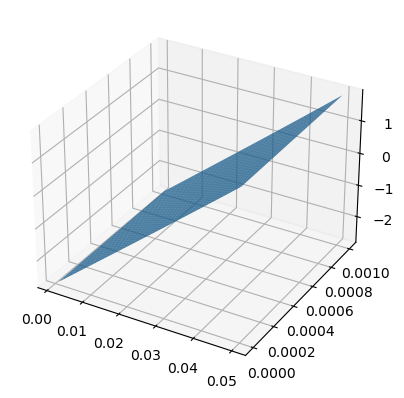

In [26]:
import matplotlib.pyplot as plt

#lets see the model
#[pr,pz,pV] = load_training_data(num=140000)
rnew = np.linspace(Lx_min, Lx_max,100)
znew = np.linspace(Ly_min, Ly_max,100)

# Generate a grid of (r, z) pairs
rnew, znew = np.meshgrid(rnew, znew)
rz_pred = np.vstack([rnew.ravel(), znew.ravel()]).T


#PredictedGeometry = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
PredictedOutcome = model.predict(rz_pred)

# reshape the predicted outcomes into the same shape as your rnew and znew grids
predicted_outcome_reshaped = PredictedOutcome.reshape(rnew.shape)

# create a 2D contour plot
plt.contourf(rnew, znew, predicted_outcome_reshaped)

# or, for a 3D surface plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(rnew, znew, predicted_outcome_reshaped)

plt.show()

In [4]:
#simple rheometer flow
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib as plt
import numpy as np
import tensorflow as tf
from deepxde.backend import tfhelper
from deepxde.boundarycondition import BC

class IntegralBC(BC):
    def __init__(self, geom, func, on_boundary, quad_deg=20):
        super(IntegralBC, self).__init__(geom, on_boundary)
        self.func = func

        # Set up Gauss-Legendre quadrature
        quad_x, quad_w = np.polynomial.legendre.leggauss(quad_deg)
        # Map quadrature points and weights from [-1,1] to [0,1]
        self.quad_pts = 0.5 * (quad_x + 1)
        self.quad_wts = 0.5 * quad_w

    def error(self, X, y, outputs):
        quad_error = 0
        for x, w in zip(self.quad_pts, self.quad_wts):
            X_quad = X * (1 - x) + self.geom.boundary_points() * x
            y_quad = self.func(X_quad)
            quad_error += w * tfhelper.square(y_quad - outputs)
        return quad_error









#Import BC at some point

#viscosity initial guess
eta =  dde.Variable(5.0)

#########################
#some properties of system
#radius in meters
R = 0.050 #5 cm
#height in meteres
H = 0.001 #1 mm





#########################
#make domain
#our domain is pseudo steady state, time invariant. Axisymmetric wrt theta
geom = dde.geometry.Rectangle([0, 0], [R, H])


#define our sysyem?
#x represents r,z, y represents theta
def rheometerPlate(x,y)
    dtheta =  y[:, 0:1]
    r = x[:,0:1]
    z = x[:,1:2]
    
    
    
    
    dtheta_r = dde.grad.jacobian(dtheta*r, x, i=0) 
    dtheta_r_r = dde.grad.jacobian(dtheta_r*(1/r), x, i=0) 
    dtheta_zz = dde.grad.hessian(dtheta,x,i=1, j = 1)
    
    
    
     # calculate dV/dx
    #V_x = tf.gradients(V, x1)[0]  

    # calculate d/dx(1/x*dV/dx)
    # term = tf.gradients((1 / x1) * V_x, x1)[0]
    #we have indep variables t, theta and z, we have dep variabels theta. We have first order and second order things
    
    eqn = eta*(dtheta_r_r+dtheta_zz)
    return eqn


space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

def boundary(_, on_initial):
    return on_initial

ic1 = dde.icbc.IC(geom, lambda X: 1, boundary, component=0)

def gen_traindata():
    #get from test file
    data = np.load("dataset/Lorenz.npz")
    return data["t"], data["y"]

def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[1], Ly_min)

def func(x):
    return x[:, 0:1]  # for example

def boundary2(x, on_boundary):
    return on_boundary and np.isclose(x[0], Lx_min)
def boundary3(x, on_boundary):
    return on_boundary and np.isclose(x[1], Ly_max)    

# Get the train data
observe_t, ob_y = gen_traindata()
#observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
#observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
#observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

bc = dde.DirichletBC(geom, lambda x: 0, boundary)
bc2 = dde.DirichletBC(geom, lambda x: 0, boundary2)
bc3 = IntegralBC(geom, func, boundary3)

Compiling model...
'compile' took 0.000159 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [6.91e-01, 3.12e-01, 1.69e+00, 6.40e+01, 4.90e+01, 7.29e+02, 3.09e+01, 4.27e+01, 2.40e+02]    [6.91e-01, 3.12e-01, 1.69e+00, 6.40e+01, 4.90e+01, 7.29e+02, 3.09e+01, 4.27e+01, 2.40e+02]    []  
1000      [4.99e+00, 3.36e+00, 3.78e+00, 3.32e+01, 5.45e-03, 1.66e+00, 3.29e+01, 7.32e+00, 1.10e+01]    [4.99e+00, 3.36e+00, 3.78e+00, 3.32e+01, 5.45e-03, 1.66e+00, 3.29e+01, 7.32e+00, 1.10e+01]    []  
2000      [8.95e+00, 1.94e+00, 1.28e+00, 1.59e+01, 3.32e-01, 1.53e+00, 3.28e+01, 1.69e+01, 3.82e+00]    [8.95e+00, 1.94e+00, 1.28e+00, 1.59e+01, 3.32e-01, 1.53e+00, 3.28e+01, 1.69e+01, 3.82e+00]    []  
3000      [8.53e+00, 1.96e+00, 8.74e-01, 1.28e+01, 3.94e-01, 1.45e+00, 3.29e+01, 1.94e+01, 2.62e+00]    [8.53e+00, 1

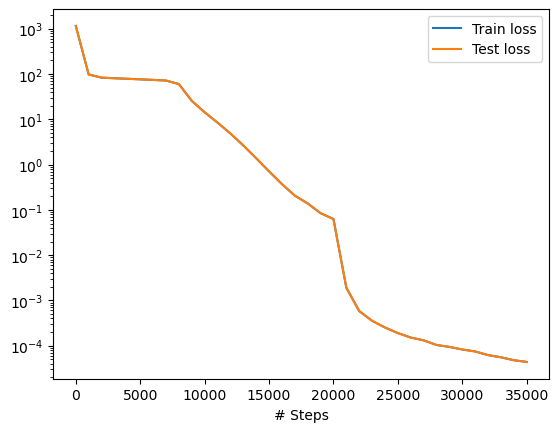

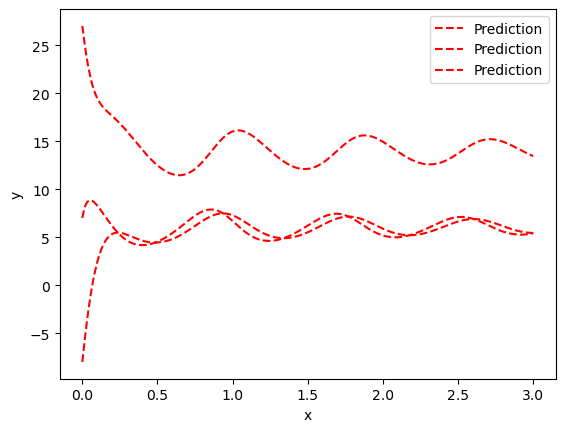

In [4]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib as plt


def gen_traindata():
    data = np.load("./Lorenz.npz")
    return data["t"], data["y"]


C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)
C3 = dde.Variable(1.0)

# Most backends
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]


# Backend JAX
# def Lorenz_system(x, y, unknowns=[C1, C2, C3]):
#     C1, C2, C3 = unknowns
#     y_val, y_fn = y
#     y1, y2, y3 = y_val[:, 0:1], y_val[:, 1:2], y_val[:, 2:3]
#     dy1_x, _ = dde.grad.jacobian(y, x, i=0)
#     dy2_x, _ = dde.grad.jacobian(y, x, i=1)
#     dy3_x, _ = dde.grad.jacobian(y, x, i=2)
#     return [
#         dy1_x - C1 * (y2 - y1),
#         dy2_x - y1 * (C2 - y3) + y2,
#         dy3_x - y1 * y2 + C3 * y3,
#     ]


def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.icbc.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 27, boundary, component=2)

# Get the train data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [C1, C2, C3]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# train adam
model.compile(
    "adam", lr=0.001, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# train lbfgs
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

ValueError: Argument Z must be 2-dimensional.

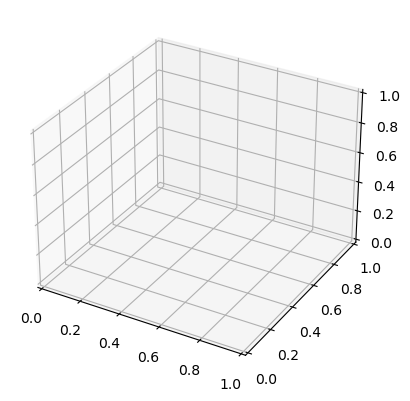

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the radius and height
R = 5
H = 10

# Set the number of points
points = 100

# Create the vectors for r, theta, and z
r = np.linspace(0, R, points)
theta = np.linspace(0, 2.*np.pi, points)
z = np.linspace(0, H, points)

# Create a 2D grid for r and theta
r, theta = np.meshgrid(r, theta)

# Convert to Cartesian coordinates
x = r * np.cos(theta)
y = r * np.sin(theta)
z = z

# Plot the surface
ax.plot_surface(x, y, z, color='b')

plt.show()